<a href="https://colab.research.google.com/github/easy-min/dacon_/blob/main/dacon_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import preprocessing # Import LabelEncoder
from sklearn.preprocessing import MinMaxScaler # 정규화
from sklearn.preprocessing import StandardScaler # 표준화

import warnings
warnings.filterwarnings("ignore")

In [24]:
train = pd.read_csv("/content/drive/My Drive/dacon/g/train.csv")
test = pd.read_csv("/content/drive/My Drive/dacon/g/test.csv")
sub = pd.read_csv('/content/drive/My Drive/dacon/g/sample_submission.csv')
train = train.drop(["ID"], axis = 1)
test = test.drop(["ID"], axis = 1)

In [10]:
train.describe()

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
count,2207.000000,2207.00000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,...,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000
mean,406.222474,243.72995,315.186226,358.824196,337.005211,3.774807,3.736928,3.701495,3.663435,3.627503,...,68.992036,68.890661,68.791536,68.692934,68.593709,68.493569,68.393050,68.291350,68.192009,68.093096
std,218.978302,35.88914,66.327994,68.862898,64.859684,0.774181,0.764067,0.754751,0.745394,0.733896,...,4.124586,4.124429,4.125817,4.128586,4.130005,4.130072,4.131859,4.134976,4.135591,4.136995
min,1.000000,95.00000,95.000000,123.000000,109.000000,2.300000,2.200000,2.200000,2.200000,2.200000,...,54.246243,54.154888,54.143798,54.028089,53.884892,53.695860,53.649032,53.644994,53.450069,53.379849
25%,221.000000,223.00000,271.500000,313.500000,294.000000,3.100000,3.100000,3.050000,3.000000,3.000000,...,66.195524,66.075372,65.995234,65.906703,65.765257,65.691065,65.609606,65.487863,65.374528,65.278624
50%,404.000000,243.00000,316.000000,364.000000,340.500000,3.800000,3.700000,3.700000,3.700000,3.600000,...,69.048956,68.920295,68.841060,68.731164,68.647716,68.514740,68.392436,68.292889,68.207648,68.102235
75%,593.500000,267.00000,361.000000,402.000000,380.000000,4.400000,4.400000,4.300000,4.300000,4.300000,...,71.740281,71.615746,71.504264,71.390195,71.311027,71.227033,71.152030,71.038257,70.947707,70.850934
max,799.000000,381.00000,559.000000,584.000000,571.500000,5.300000,5.300000,5.200000,5.200000,5.100000,...,83.363883,83.227379,83.036103,82.978876,82.842139,82.722266,82.575149,82.491041,82.371832,82.321938


In [11]:
X = train.drop(['착과량(int)'], axis = 1)
y = train['착과량(int)']

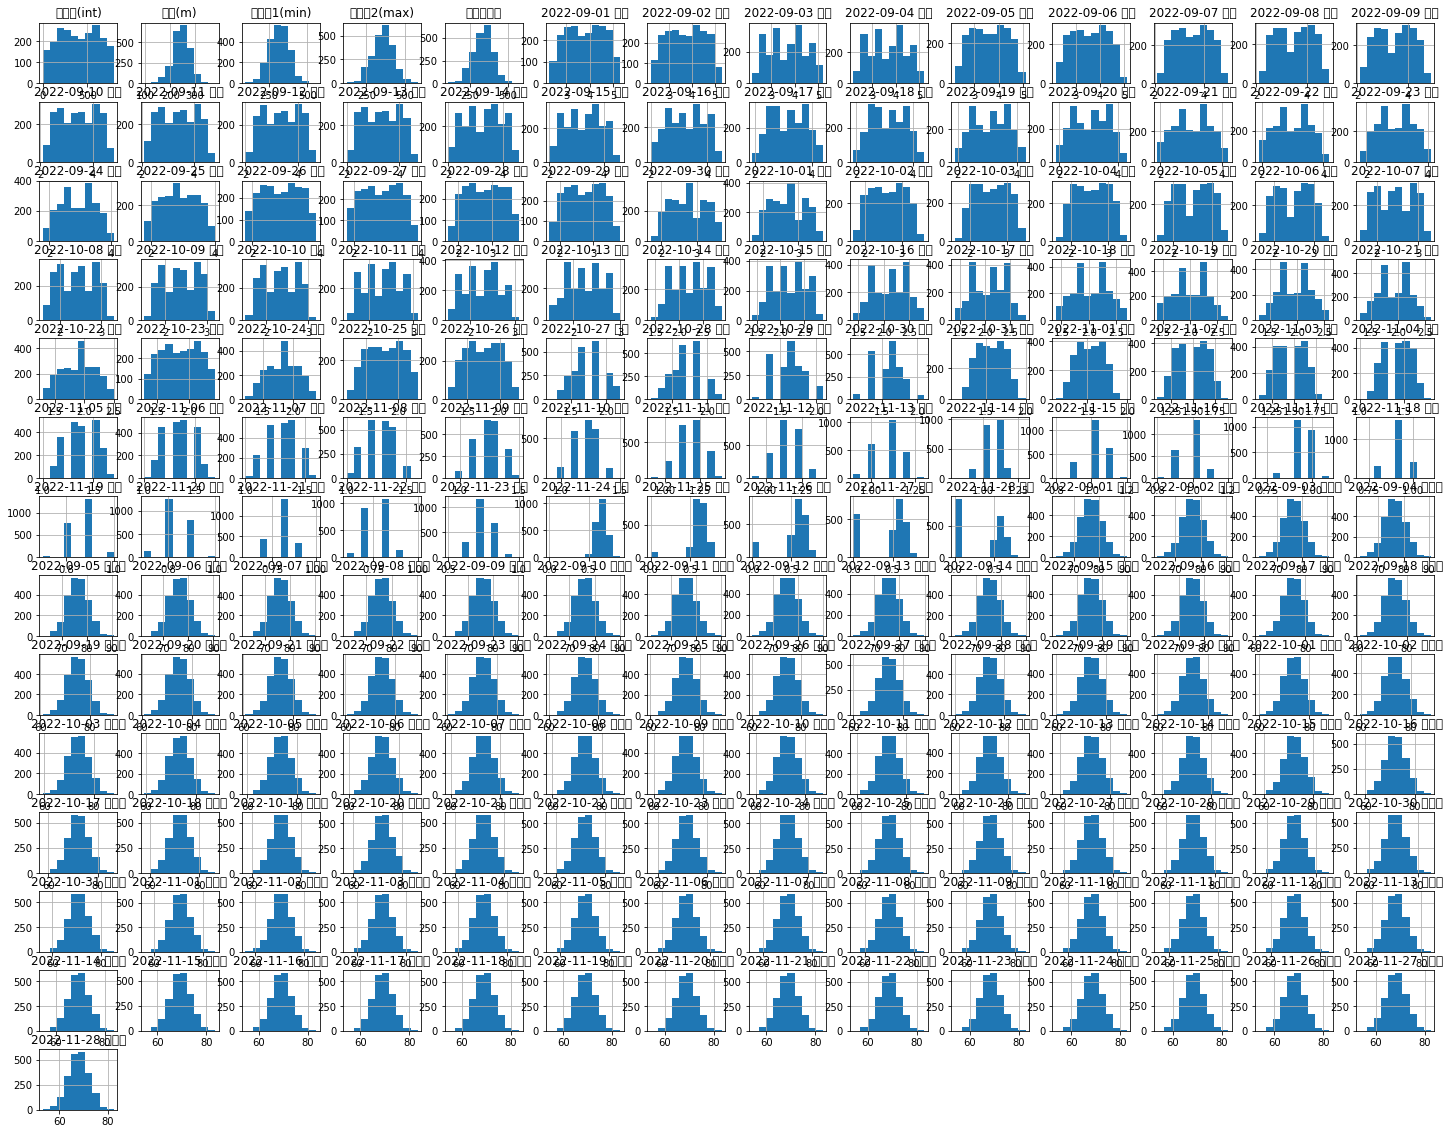

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]
train.hist(figsize=(25,20));

In [21]:
import lightgbm #lightgbm
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [13]:
# NMAE (Normalized Mean Absolute Error)는 척도가 다른 데이터 세트의 MAE에 관한 비교를 용이하게 하기 위해서 정규화를 적용
def nmae(true, pred):
    return mae(true, pred) / 406.22247394653374

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [14]:
def permutation_importances(model, vv): # 변수 중요도
    use_features = vv[0].columns
    oof = model.predict(vv[0])
    base_score = mae(vv[1], oof)

    good_features = []
    for col in use_features:
        test = vv[0].copy()
        test[col] = np.random.permutation(test[col])
        permu_oof = model.predict(test)
        permu_score = mae(vv[1], permu_oof)
        if permu_score>base_score:
            good_features += [col]
    return good_features

In [27]:
def main():
    
    target = '착과량(int)'
    

    seed_permu_oof = []
    seed_permu_prediction = []
    seed_ff_oof = []
    seed_ff_prediction = []
    FOLDS = 10
    SEEDS = [10, 30, 50, 70]
    
    for seed in SEEDS:
        seed_everything(seed=seed)

        kf = KFold(n_splits=FOLDS, random_state=seed, shuffle=True) # split 개수, 셔플 여부 및 seed 설정
        splits = list(kf.split(train))

        drop_cols = ['ID']
        drop_cols += [col for col in train.columns if '새순' not in col]

        feature_importacne_df = pd.DataFrame() # 변수 중요도도
        use_cols = [col for col in train.columns if col not in drop_cols + [target]]
        oof = np.zeros(len(train))
        prediction = np.zeros(len(test))

        for fold, (trn_idx, val_idx) in enumerate(splits):
            print(f'-------------------------- {fold}/{FOLDS} --------------------------')
            tt = (train.loc[trn_idx, use_cols], train.loc[trn_idx, target])
            vv = (train.loc[val_idx, use_cols], train.loc[val_idx, target])

            reg = LGBMRegressor(
                            objective='regression',# regression, regression_l1, poisson, poisson
                            n_estimators=10000,
                            learning_rate=0.01,
                            max_depth=-1,
                            # num_leaves=64,
                            subsample=0.7,
                            colsample_bytree=0.3,
                            random_state=seed,
                            # reg_alpha=0.01,
                            # reg_lambda=0.01,
                            )
            reg.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            permu_features = permutation_importances(reg, vv)
            use_cols = permu_features
            tt = (train.loc[trn_idx, use_cols], train.loc[trn_idx, target])
            vv = (train.loc[val_idx, use_cols], train.loc[val_idx, target])
            
            reg.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            oof[val_idx] = reg.predict(vv[0])
            prediction += reg.predict(test[use_cols]) / FOLDS
            feature_importacne_df = feature_importacne_df.append(pd.DataFrame(zip(use_cols, reg.feature_importances_), columns=['feature', 'value']))

        feature_importacne_df = feature_importacne_df.groupby('feature').mean().sort_values('value', ascending=False).reset_index()
        print(nmae(train[target], oof), mae(train[target], oof), mse(train[target], oof))
        seed_permu_oof += [oof]
        seed_permu_prediction += [prediction]

    
    for seed in SEEDS:
        seed_everything(seed=seed)

        kf = KFold(n_splits=FOLDS, random_state=seed, shuffle=True)
        splits = list(kf.split(train))

        drop_cols = ['ID']
        drop_cols += [col for col in train.columns if '새순' not in col]

        feature_importacne_df = pd.DataFrame()
        use_cols = [col for col in train.columns if col not in drop_cols + [target]]
        oof = np.zeros(len(train))
        prediction = np.zeros(len(test))

        for fold, (trn_idx, val_idx) in enumerate(splits):
            print(f'-------------------------- {fold}/{FOLDS} --------------------------')
            tt = (train.loc[trn_idx, use_cols], train.loc[trn_idx, target])
            vv = (train.loc[val_idx, use_cols], train.loc[val_idx, target])

            reg = LGBMRegressor(
                            objective='regression',# regression, regression_l1, poisson, poisson
                            n_estimators=10000,
                            learning_rate=0.01,
                            max_depth=-1,
                            # num_leaves=64,
                            subsample=0.7,
                            colsample_bytree=0.3,
                            random_state=seed,
                            # reg_alpha=0.01,
                            # reg_lambda=0.01,
                            )
            reg.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            oof[val_idx] = reg.predict(vv[0])
            prediction += reg.predict(test[use_cols]) / FOLDS
            feature_importacne_df = feature_importacne_df.append(pd.DataFrame(zip(use_cols, reg.feature_importances_), columns=['feature', 'value']))
        feature_importacne_df = feature_importacne_df.groupby('feature').mean().sort_values('value', ascending=False).reset_index()

        use_cols = feature_importacne_df.iloc[:20, 0].tolist()
        oof = np.zeros(len(train))
        prediction = np.zeros(len(test))

        for fold, (trn_idx, val_idx) in enumerate(splits):
            print(f'-------------------------- {fold}/{FOLDS} --------------------------')
            tt = (train.loc[trn_idx, use_cols], train.loc[trn_idx, target])
            vv = (train.loc[val_idx, use_cols], train.loc[val_idx, target])

            lr = LGBMRegressor(
                            objective='regression',# regression, regression_l1, poisson
                            n_estimators=10000,
                            learning_rate=0.01,
                            max_depth=-1,
                            # num_leaves=64,
                            subsample=0.7,
                            colsample_bytree=0.3,
                            random_state=seed,
                            # reg_alpha=0.01,
                            # reg_lambda=0.01,
                            )
            lr.fit(tt[0], tt[1], eval_set=[tt, vv], early_stopping_rounds=200, verbose=500)

            oof[val_idx] = lr.predict(vv[0])
            prediction += lr.predict(test[use_cols]) / FOLDS

        seed_ff_oof += [oof]
        seed_ff_prediction += [prediction]
        
    sub[target] = np.mean(seed_permu_prediction, 0)*0.5 + np.mean(seed_ff_prediction, 0)*0.5
    sub.to_csv('/content/drive/My Drive/dacon/g/sample_submission.csv', index=False)


if __name__=='__main__':
    main()

-------------------------- 0/10 --------------------------
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 956.859	valid_1's l2: 1413.36
Early stopping, best iteration is:
[474]	training's l2: 970.827	valid_1's l2: 1411.39
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 1009.83	valid_1's l2: 1391.96
Early stopping, best iteration is:
[438]	training's l2: 1039.87	valid_1's l2: 1385.51
-------------------------- 1/10 --------------------------
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 1030.96	valid_1's l2: 1189.36
Early stopping, best iteration is:
[520]	training's l2: 1022.4	valid_1's l2: 1187.69
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 1081.77	valid_1's l2: 1183.66
Early stopping, best iteration is:
[456]	training's l2: 1100.09	valid_1's l2: 1181.69
-------------------------- 2/10 --------------------------
Training until validatio